In [873]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm as cmaps
from pylab import rcParams
import healpy as hp
from tqdm import *
from astropy import units as u
from scipy.ndimage.filters import gaussian_filter

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [874]:
from plot_params import params
import matplotlib.pylab as pylab

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

alpha_plot = 1.
lw_plot = 2.5

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsha

In [875]:
# pylab.rcParams.update(params)
# plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/Draft/plots/"
# plots_dir = "/Users/smsharma/Desktop/LensPower_Offline/plots/"

# data_dir = "/Users/smsharma/QuasarSims/"

In [876]:
## Function to get 95% containment limit

# Calculate exact TS threshold (around ~2.71)
delta_chi2_thresh = chi2.isf(1 - .68, 1)

from scipy.optimize import brentq

def get_lim(delta_chi2_ary, eps_ary):
    """ Get one-sided 95% containment limits. `delta_chi2_ary` must have shape (len(m_Ap_ary), len(self.eps_ary)).
        Returns limit array of length len(m_Ap_ary), over each mass index.
    """

    TS_m_xsec = np.zeros(3)

    TS_m_xsec[2] = eps_ary[0]

    lim_ary = np.zeros(len(delta_chi2_ary))

    for i_m in range(len(delta_chi2_ary)):

        TS_eps_ary = np.nan_to_num(delta_chi2_ary[i_m], nan=1e10)

        # Find value, location and xsec at the max TS (as a function of mass)
        max_loc = np.argmin(TS_eps_ary)
        max_TS = TS_eps_ary[max_loc]

        if max_TS > TS_m_xsec[0]:
            TS_m_xsec[0] = max_TS
            TS_m_xsec[1] = i_m
            TS_m_xsec[2] = eps_ary[max_loc]
        
        upper_crossing = []
        # Calculate limit
        for xi in range(max_loc, len(eps_ary)):
            val = TS_eps_ary[xi]
            if val > delta_chi2_thresh:
                interp = interp1d(np.log10([eps_ary[xi-1], eps_ary[xi]]),[TS_eps_ary[xi-1], TS_eps_ary[xi]])
                upper_crossing = 10 ** brentq(lambda eps: interp(eps) - delta_chi2_thresh, np.log10(eps_ary[xi-1]), np.log10(eps_ary[xi]))
                break
                
        # Calculate limit
        for xi in range(0, max_loc):
            val = TS_eps_ary[xi]
            if val < delta_chi2_thresh:
                interp = interp1d(np.log10([eps_ary[xi - 1], eps_ary[xi]]),[TS_eps_ary[xi - 1], TS_eps_ary[xi]])
                lower_crossing = 10 ** brentq(lambda eps: interp(eps) - delta_chi2_thresh, np.log10(eps_ary[xi - 1]), np.log10(eps_ary[xi]))
                break

    return upper_crossing - lower_crossing    
    


In [877]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=200., alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

sim.analysis_pipeline(get_sample=True)

Simulating 1600 subhalos between 7.0 and 10.0


/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  This is separate from the ipykernel package so we can avoid doing imports until


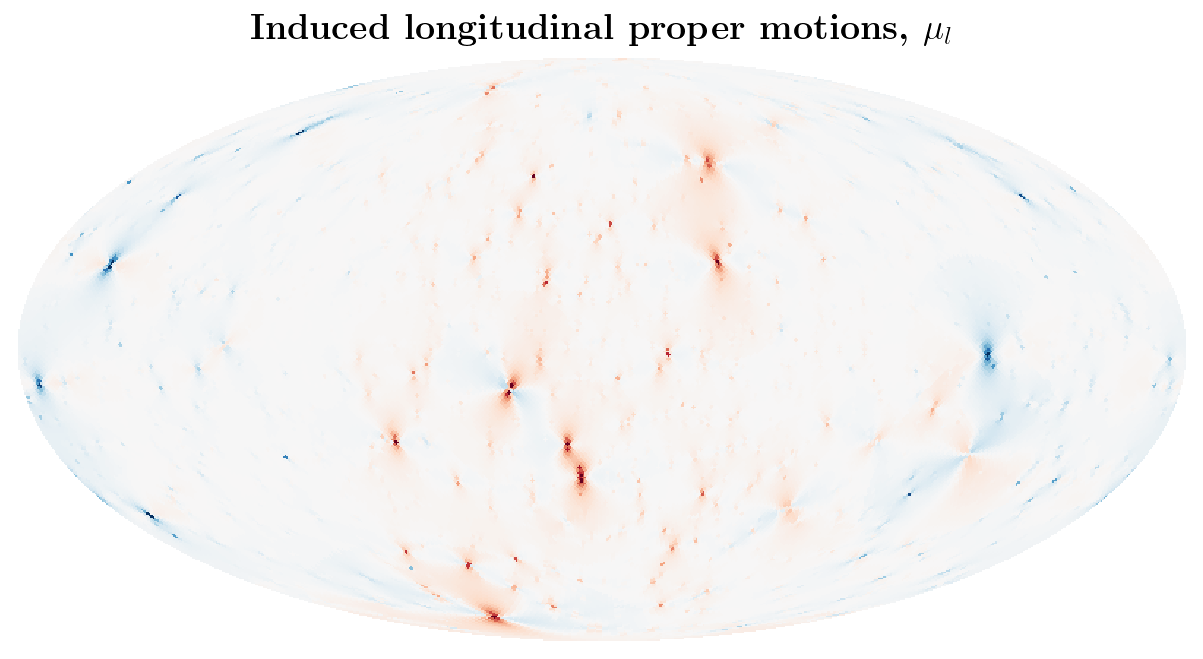

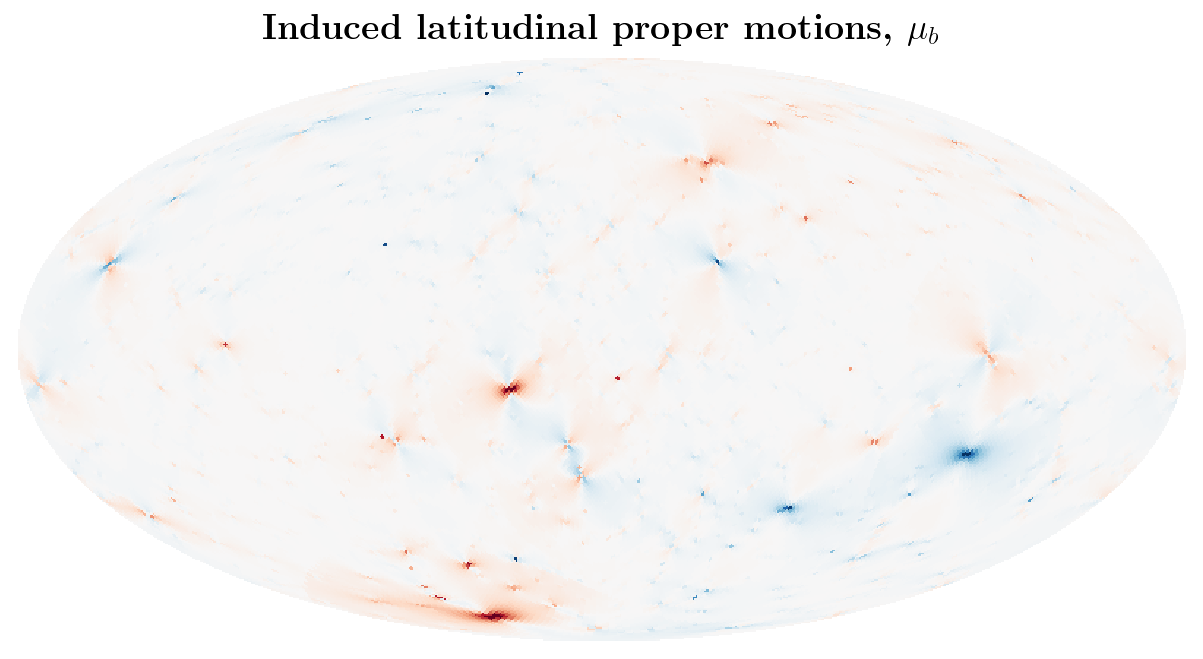

In [878]:
max_mu = 8e-4 / 0.6e-4
cmap = cmaps.RdBu_r
cmap.set_under('w')

hp.mollview(1e6 * sim.mu_qsrs[:,0] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced longitudinal proper motions}, $\mu_l$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)
hp.mollview(1e6 * sim.mu_qsrs[:,1] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced latitudinal proper motions}, $\mu_b$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)

In [879]:
import sys
sys.path.append("../")

from models.embedding import SphericalGraphCNN

In [880]:
nside_list = [64, 32, 16, 8, 4, 2, 1]

In [881]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, mask_ring = False)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])


In [882]:
import torch
in_map = torch.Tensor((sim.mu_qsrs.reshape((1, -1, 2))))
in_map.shape

torch.Size([1, 49152, 2])

In [883]:
log_mean = torch.log(torch.mean(in_map, axis=1))
log_std = torch.log(torch.var(in_map, axis=1).sqrt())

log_mean = log_mean.reshape((1, -1, 2))
log_std = log_std.reshape((1, -1, 2))

data_map = torch.cat([in_map], axis=1)
data_map.shape

torch.Size([1, 49152, 2])

In [884]:
data_map = data_map.view(-1, 2, 49152)

In [885]:
sg = SphericalGraphCNN(nside_list, indexes_list, in_ch=2)

In [886]:
data_map = torch.cat(4 * [data_map])

In [887]:
data_map.shape

torch.Size([4, 2, 49152])

In [888]:
theta = torch.ones([4, 1000])

In [889]:
sg(data_map, theta).shape

torch.Size([4, 64])


## Analysis

In [890]:
import sys
sys.path.append("../")
from sbi.neural_nets.flow import build_maf

from sbi.neural_nets.classifier import build_mlp_mixed_classifier
from sbi import utils
import torch

In [892]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '1936d60ac8f945b4b6873c96a4946f32'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-astrometry/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

In [893]:
from tqdm.notebook import tqdm

In [894]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

In [895]:
list(density_estimator.children())[0].add_noise.sigma = 0.

In [896]:
n_trials = 30
n_test = 30

out = np.zeros((n_trials, n_test))

for i_trial in tqdm(range(n_trials)):
    
    sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150., alpha=-1.9)
    sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
    sim.set_subhalo_properties(sim.c200_SCP, distdep=False)
    
    sim.analysis_pipeline(get_sample=True)
    sim.mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T
    
    x_test = torch.Tensor(sim.mu_qsrs)
    
    gn = GaussianNoise(sigma=0.0023)
    x_test = gn(x_test).T
    
#     x_test = torch.Tensor(1 * [x_test.T]).contiguous() 

    theta_test = torch.linspace(10., 300., n_test).unsqueeze(1)

    out[i_trial, :] = [density_estimator(x_test.unsqueeze(0), theta_test
                                         [i].unsqueeze(0)).squeeze().detach().numpy() \
           for i in (range(n_test))]

  0%|          | 0/30 [00:00<?, ?it/s]

Simulating 1188 subhalos between 7.0 and 10.0


Simulating 1199 subhalos between 7.0 and 10.0
Simulating 1206 subhalos between 7.0 and 10.0
Simulating 1253 subhalos between 7.0 and 10.0
Simulating 1194 subhalos between 7.0 and 10.0
Simulating 1172 subhalos between 7.0 and 10.0
Simulating 1191 subhalos between 7.0 and 10.0
Simulating 1186 subhalos between 7.0 and 10.0
Simulating 1226 subhalos between 7.0 and 10.0
Simulating 1190 subhalos between 7.0 and 10.0
Simulating 1211 subhalos between 7.0 and 10.0
Simulating 1184 subhalos between 7.0 and 10.0
Simulating 1209 subhalos between 7.0 and 10.0
Simulating 1162 subhalos between 7.0 and 10.0
Simulating 1196 subhalos between 7.0 and 10.0
Simulating 1222 subhalos between 7.0 and 10.0
Simulating 1212 subhalos between 7.0 and 10.0
Simulating 1229 subhalos between 7.0 and 10.0
Simulating 1248 subhalos between 7.0 and 10.0
Simulating 1148 subhalos between 7.0 and 10.0
Simulating 1198 subhalos between 7.0 and 10.0
Simulating 1218 subhalos between 7.0 and 10.0
Simulating 1161 subhalos between 7

In [897]:
out_mean = np.mean(out, axis=0)

In [898]:
from scipy.stats import chi2
from scipy.stats import norm

In [986]:
llrmin, llrmax = 0., 15.

for out_inst in out:
    llr = - 2 * out_inst
    llr -= np.min(llr)
    llr = np.clip(llr, llrmin, llrmax)
    
    try:
        print(get_lim(np.expand_dims(llr[1:], 0), theta_test.squeeze().detach().numpy()[1:]))
    except:
        continue

118.9841812910058
113.59948290350282
112.4988469540371
123.63950773680762
131.21410874826972
120.87266508174267
114.66028199456566
121.2889213145218
119.30107809107007
117.23311177839588
113.42536807461637
119.77094785692822
115.4074930275356
119.24295003224881
118.14862567321455
115.69053587087853
120.6502067101924
115.50107542138117
119.0621769259013
113.92361854493852
118.13859634819757
117.53721867594976
118.66127724413668
113.6361691531812
125.52441709142985
120.07915461787812
118.87323656341154
86.72271079220837
125.20125013113304


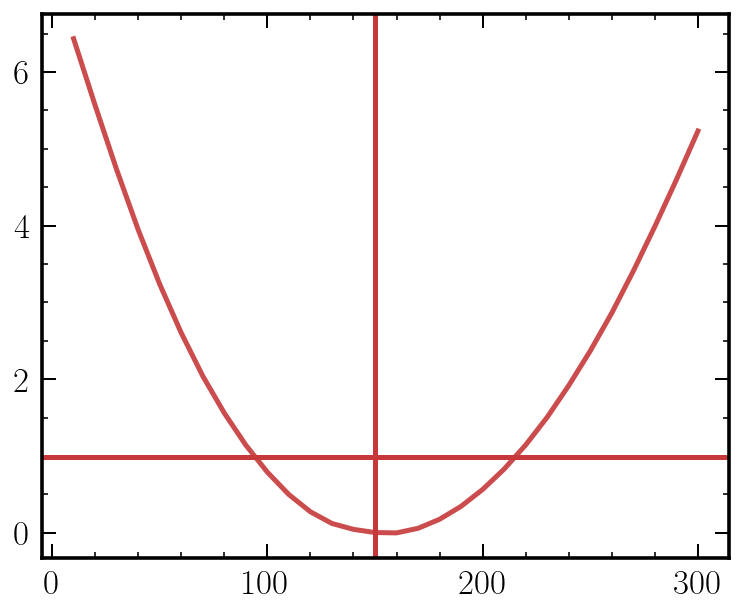

In [900]:
llrmin, llrmax = 0., 15.

llr = - 2 * out_mean
llr -= np.min(llr)
llr = np.clip(llr, llrmin, llrmax)

plt.plot(theta_test.squeeze().detach().numpy(), llr)

plt.axhline(chi2.isf(1 - .68, 1))
plt.axvline(150)

In [901]:
from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

In [902]:
# Precompute some number for NFW and Burkert
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

In [903]:
# Calculate spectra for fiducial CDM

pspecpop = PowerSpectraPopulations(l_max=2000)

pspecpop.set_radial_distribution(pspecpop.r2rho_V_ein_EAQ, R_min=1e-3*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e7*M_s, M_max=1e10*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1.1e10*M_s, N_calib=150, alpha=-1.9)
pspecpop.set_subhalo_properties(pspecpop.c200_SCP)

C_l_mu = pspecpop.get_C_l_total_ary();

  0%|          | 0/50 [00:00<?, ?it/s]

In [990]:
# Test

sigma_mu = .1
sigma_alpha = None
N_q = 1e8

fDM_base = 1
dfDM_base = 0.1

Cl_ary_fid = pspecpop.C_l_ary*fDM_base

p = pspecpop.C_l_ary*(fDM_base + dfDM_base)
m = pspecpop.C_l_ary*(fDM_base - dfDM_base)

fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                None, None, '$\\f_\mathrm{DM}$' )

In [991]:
M_calib_ary = np.logspace(8, 10) * M_s
calib = 150 / np.trapz(pspecpop.rho_M_SI(M_calib_ary, alpha=-1.9), M_calib_ary)

M_ary = np.logspace(-6, 10) * M_s
f_sub_fid = np.trapz(M_ary * calib * pspecpop.rho_M_SI(M_ary, alpha=-1.9), M_ary) / M_MW

0.1280184991297499
0.2153241974261756


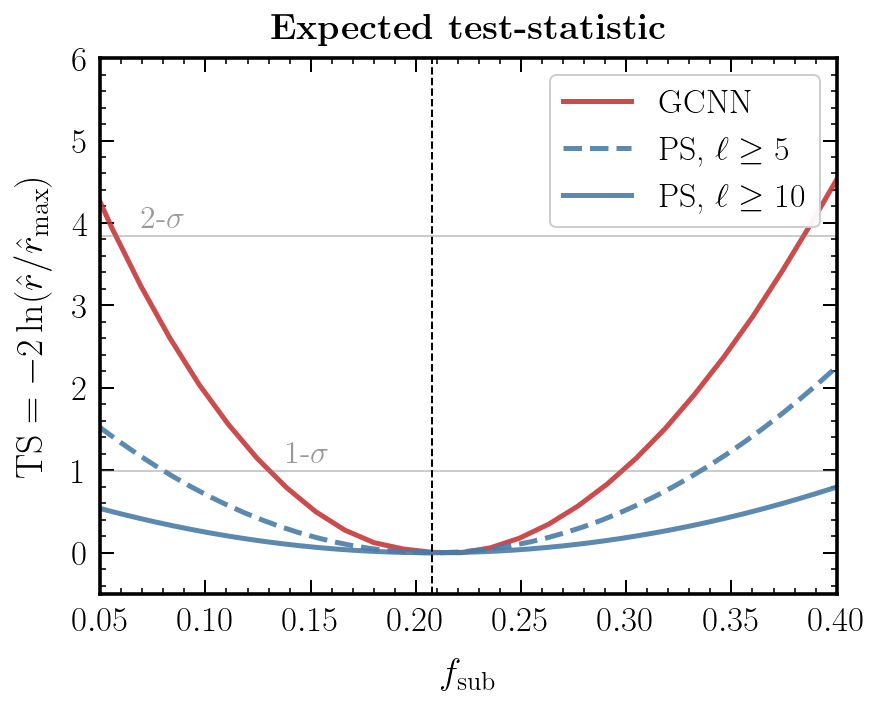

In [993]:
signal = np.linspace(1e-3, 2, 100)

ls_list = ['--', '-']


llrmin, llrmax = 0., 15.

llr = - 2 * out_mean
llr -= np.min(llr)
llr = np.clip(llr, llrmin, llrmax)

offset = 0  # (f_sub_fid - (f_sub_fid / 150) * theta_test.squeeze().detach().numpy()[np.argmin(llr[1:]) + 1])
plt.plot(offset + (f_sub_fid / 150) * theta_test.squeeze().detach().numpy(), llr, label="GCNN", color=cols_default[0])

for i_l, l_min in enumerate([5, 10]):

    parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
    observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=l_min, l_max_mu=300, l_min_alpha=200, l_max_alpha=2000)

    fshr = FisherForecast(parameters, observation)

    sigma=fshr.pars_vary[0].sigma

    x_arr=np.linspace(0, 2)
    LL_ary = norm.logpdf(x_arr, fDM_base, sigma)
    plt.plot(f_sub_fid * x_arr, -2 * (LL_ary - np.max(LL_ary)), label=r"PS, $\ell \geq {}$".format(l_min), ls=ls_list[i_l], color=cols_default[1])
    
    print(fshr.pars_vary[0].sigma * f_sub_fid)


plt.axhline(chi2.isf(1 - .95, 1), color='grey', alpha=0.4, lw=1)
plt.text(f_sub_fid / 3, chi2.isf(1 - .95, 1) + 0.1, r"2-$\sigma$",  color='grey', alpha=0.8, fontsize=16)

plt.axhline(chi2.isf(1 - .68, 1), color='grey', alpha=0.4, lw=1)
plt.text(f_sub_fid / (3 / 2), chi2.isf(1 - .68, 1) + 0.1, r"1-$\sigma$",  color='grey', alpha=0.8, fontsize=16)

plt.axvline(f_sub_fid, color='k', lw=1, ls='--')

plt.ylim(-0.5, 6)
plt.xlim(0.05, 0.4)



plt.legend(loc='upper right', frameon=True, framealpha=0.95)

plt.xlabel(r"$f_\mathrm{sub}$")
plt.ylabel(r"$\mathrm{TS}  = -2 \ln  (\hat r / \hat r_\mathrm{max}) $")

plt.title(r"\bf{Expected test-statistic}", y=1.008)

plt.tight_layout()
plt.savefig("../paper/ml4ps/figures/TS.pdf")

In [557]:
import healpy as hp
Sigma_q = 1e8 / (4 * np.pi)
pixarea = hp.nside2pixarea(nside=64, degrees=False)
N_q_pix = Sigma_q * pixarea
sigma_pix = .0721 / np.sqrt(N_q_pix)
sigma_pix

# the_map = np.load("../../sbi-astrometry/data/x_train_49.npy")[4, 0] 
# the_map += np.random.normal(loc=0, scale=sigma_pix, size=the_map.shape)
# hp.mollview(the_map, nest=True, cmap='RdBu_r')

0.0015984750492891654

In [90]:
np.linspace(0.0002, 0.005, 10)

array([0.0002    , 0.00073333, 0.00126667, 0.0018    , 0.00233333,
       0.00286667, 0.0034    , 0.00393333, 0.00446667, 0.005     ])

In [145]:
import torch.nn as nn

In [908]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
    """
    def __init__(self, sigma=0.):
        super().__init__()
        self.sigma = sigma
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.sigma != 0.:
            sampled_noise = self.noise.expand(*x.size()).detach().float().normal_() * self.sigma
            x = x + sampled_noise
        return x 

In [909]:
gn = GaussianNoise(sigma=0.0022)
x = torch.zeros((1000000))
gn(x)

tensor([-0.0009, -0.0002,  0.0035,  ...,  0.0037,  0.0021, -0.0021])

In [910]:
np.random.normal(loc=0, scale=0.0022 / 1., size=(1000000))

array([ 0.00034463,  0.00194934, -0.00024921, ..., -0.00058336,
       -0.00423482,  0.00216631])

## Variation over noise

In [911]:
run_id_list = ['303ceae8593c4ab78a573e1a3b1d83b1', '1936d60ac8f945b4b6873c96a4946f32', 'ede8a36abe9d4baf9dd8bbfbf7d0f158']

n_trials = 10
n_test = 30

lims_ary = np.zeros((len(run_id_list), n_trials))

for i_run, run_id in enumerate(run_id_list):

    data_dir = '/scratch/sm8383/sbi-fermi/data/'
    model_uri = "runs:/{}/density_estimator".format(run_id)
    density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-astrometry/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

    list(density_estimator.children())[0].add_noise.sigma = 0.


    out = np.zeros((n_trials, n_test))

    for i_trial in tqdm(range(n_trials)):

        sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150., alpha=-1.9)
        sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
        sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

        sim.analysis_pipeline(get_sample=True)
        sim.mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T

        x_test = torch.Tensor(sim.mu_qsrs)

        gn = GaussianNoise(sigma=0.0023)
        x_test = gn(x_test).T

    #     x_test = torch.Tensor(1 * [x_test.T]).contiguous() 

        theta_test = torch.linspace(10., 300., n_test).unsqueeze(1)

        out[i_trial, :] = [density_estimator(x_test.unsqueeze(0), theta_test
                                             [i].unsqueeze(0)).squeeze().detach().numpy() \
               for i in (range(n_test))]

    llrmin, llrmax = 0., 15.

    for i_trial, out_inst in enumerate(out):
        llr = - 2 * out_inst
        llr -= np.min(llr)
        llr = np.clip(llr, llrmin, llrmax)

        try:
            lim_trial = get_lim(np.expand_dims(llr[:], 0), theta_test.squeeze().detach().numpy()[:])
        except:
            lim_trial = np.nan
            continue
        
        lims_ary[i_run, i_trial] = lim_trial

  0%|          | 0/10 [00:00<?, ?it/s]

Simulating 1230 subhalos between 7.0 and 10.0


Simulating 1219 subhalos between 7.0 and 10.0
Simulating 1260 subhalos between 7.0 and 10.0
Simulating 1216 subhalos between 7.0 and 10.0
Simulating 1139 subhalos between 7.0 and 10.0
Simulating 1258 subhalos between 7.0 and 10.0
Simulating 1234 subhalos between 7.0 and 10.0
Simulating 1230 subhalos between 7.0 and 10.0
Simulating 1233 subhalos between 7.0 and 10.0
Simulating 1201 subhalos between 7.0 and 10.0


  0%|          | 0/10 [00:00<?, ?it/s]

Simulating 1152 subhalos between 7.0 and 10.0
Simulating 1190 subhalos between 7.0 and 10.0
Simulating 1211 subhalos between 7.0 and 10.0
Simulating 1248 subhalos between 7.0 and 10.0
Simulating 1225 subhalos between 7.0 and 10.0
Simulating 1254 subhalos between 7.0 and 10.0
Simulating 1218 subhalos between 7.0 and 10.0
Simulating 1199 subhalos between 7.0 and 10.0
Simulating 1233 subhalos between 7.0 and 10.0
Simulating 1242 subhalos between 7.0 and 10.0


  0%|          | 0/10 [00:00<?, ?it/s]

Simulating 1165 subhalos between 7.0 and 10.0
Simulating 1278 subhalos between 7.0 and 10.0
Simulating 1154 subhalos between 7.0 and 10.0
Simulating 1198 subhalos between 7.0 and 10.0
Simulating 1165 subhalos between 7.0 and 10.0
Simulating 1164 subhalos between 7.0 and 10.0
Simulating 1221 subhalos between 7.0 and 10.0
Simulating 1224 subhalos between 7.0 and 10.0
Simulating 1166 subhalos between 7.0 and 10.0
Simulating 1147 subhalos between 7.0 and 10.0


In [912]:
lims_ary[lims_ary == 0.] = np.nan

In [934]:
sigma_list = [0.0016, 0.0023, 0.003]

In [940]:
# l_min_list = [2, 5, 10]
l_min_list = [5, 10]

sigma_ps = np.zeros((len(l_min_list), len(sigma_list)))

for i_l, l_min in enumerate(l_min_list):
    for i_s, sigma_mu in enumerate([0.0721, 0.105, 0.132]):    
#     for i_s, sigma_mu in enumerate([0.105, 0.132]):    
        N_q = 1e8

        parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
        observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=l_min, l_max_mu=3 * nside - 1, l_min_alpha=200, l_max_alpha=2000)

        fshr = FisherForecast(parameters, observation)

        sigma=fshr.pars_vary[0].sigma
        sigma_ps[i_l, i_s] = (f_sub_fid * sigma)

In [941]:
sigma_ps.shape

(2, 3)

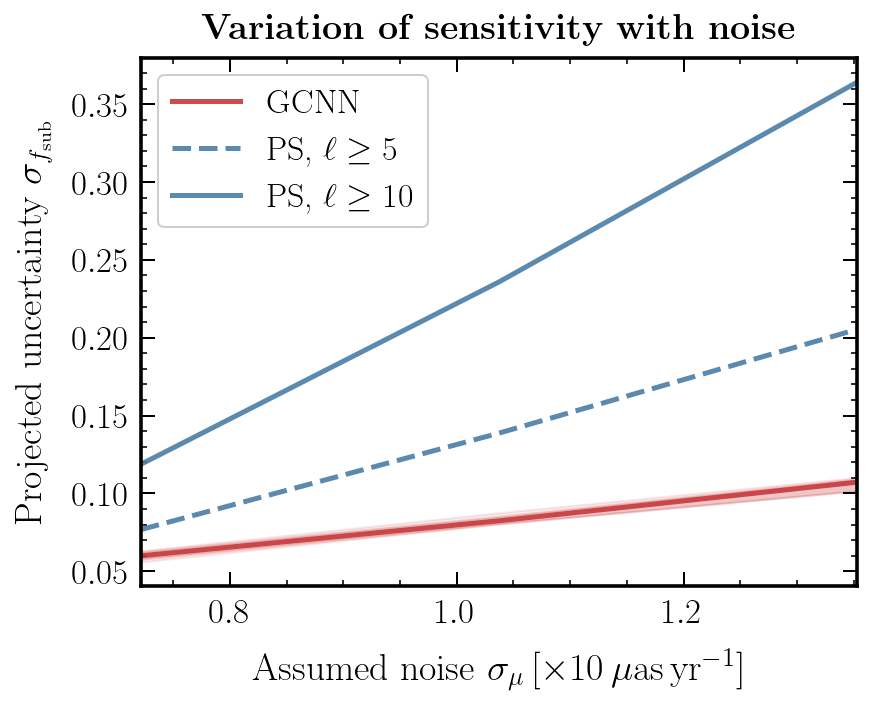

In [985]:
run_id_list = ['303ceae8593c4ab78a573e1a3b1d83b1', '1936d60ac8f945b4b6873c96a4946f32', 'ede8a36abe9d4baf9dd8bbfbf7d0f158']

perc = (f_sub_fid / 150 / 2) * np.array([np.nanpercentile(lims_ary[i], q=[2.5, 16, 50, 84, 97.5]) for i in range(len(run_id_list))])

plt.plot(np.array(sigma_list) * 10 * np.sqrt(N_q_pix), perc[:, 2], label="GCNN", color=cols_default[0])
plt.fill_between(np.array(sigma_list) * 10 * np.sqrt(N_q_pix), perc[:, 1], perc[:, 3], alpha=0.2, color=cols_default[0])
plt.fill_between(np.array(sigma_list) * 10 * np.sqrt(N_q_pix), perc[:, 0], perc[:, 4], alpha=0.1, color=cols_default[0])

for i_s, sigma_mu in enumerate(sigma_ps):
    plt.plot(np.array(sigma_list) * 10 * np.sqrt(N_q_pix), sigma_mu, label=r"PS, $\ell \ge {}$".format(l_min_list[i_s]), color=cols_default[1], ls=ls_list[i_s])
    
plt.xlim(0.0016 * 10 * np.sqrt(N_q_pix), 0.003 * 10 * np.sqrt(N_q_pix))

plt.xlabel(r"Assumed noise $\sigma_\mu\,[\times 10\,\mu$as\,yr$^{-1}$]")
plt.ylabel(r"Projected uncertainty $\sigma_{f_\mathrm{sub}}$")

plt.title(r"\bf{Variation of sensitivity with noise}", y=1.008)

plt.legend(frameon=True, framealpha=0.95)

plt.tight_layout()
plt.savefig("../paper/ml4ps/figures/noise_var.pdf")

## Correlated noise tests

In [753]:
input_map = np.zeros(hp.nside2npix(64))
sigma = 55.
grf = GaussianNoise(sigma=sigma)(torch.Tensor(input_map)).detach().numpy()

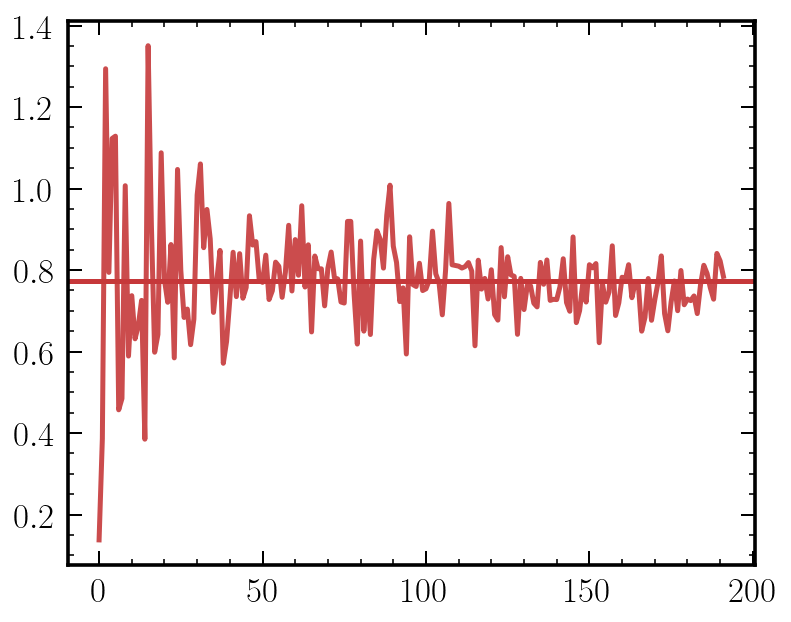

In [754]:
C_l = hp.anafast(grf)
plt.plot(C_l)

plt.axhline(sigma ** 2 * hp.nside2pixarea(64, degrees=False))

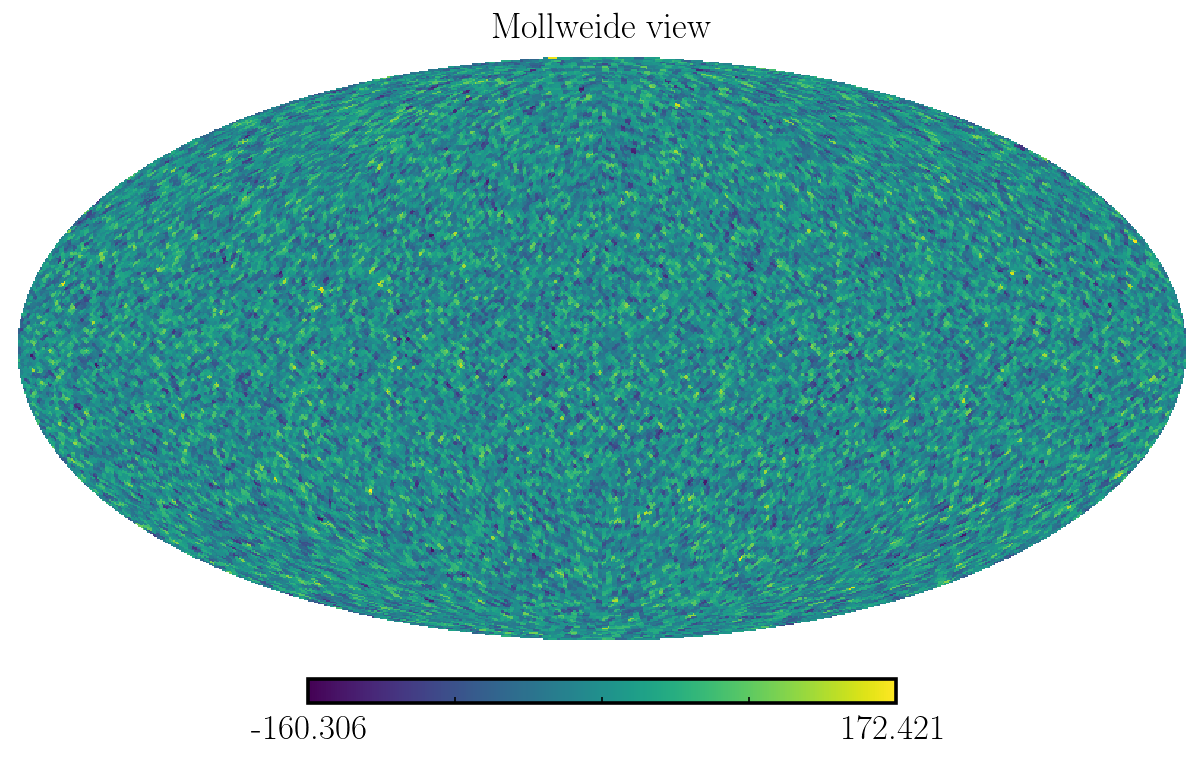

In [757]:
lmax = 64 * 3 - 1

input_cl = sigma ** 2 * hp.nside2pixarea(64, degrees=False) * np.ones(lmax + 1)
input_map = hp.synfast(input_cl, nside=64, pixwin=True)

hp.mollview(input_map)

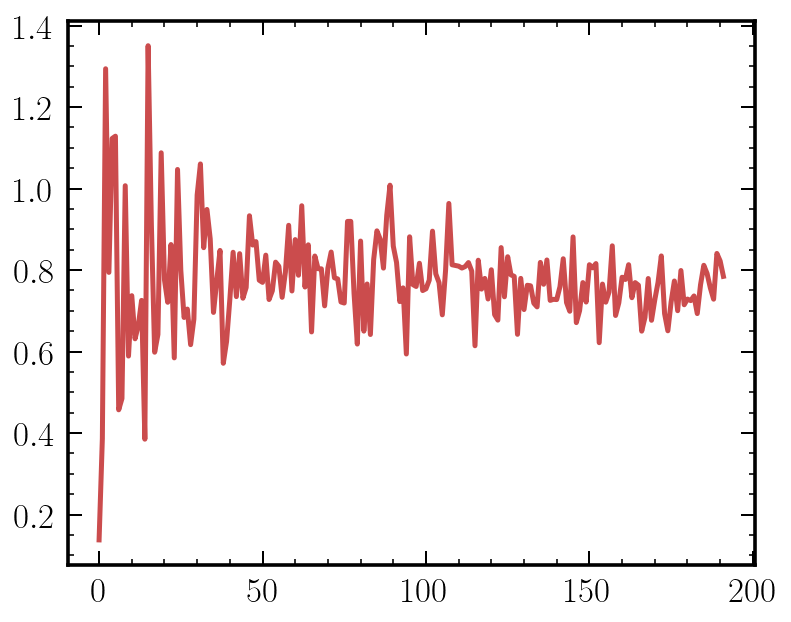

In [758]:
C_l = hp.anafast(grf)
plt.plot(C_l)

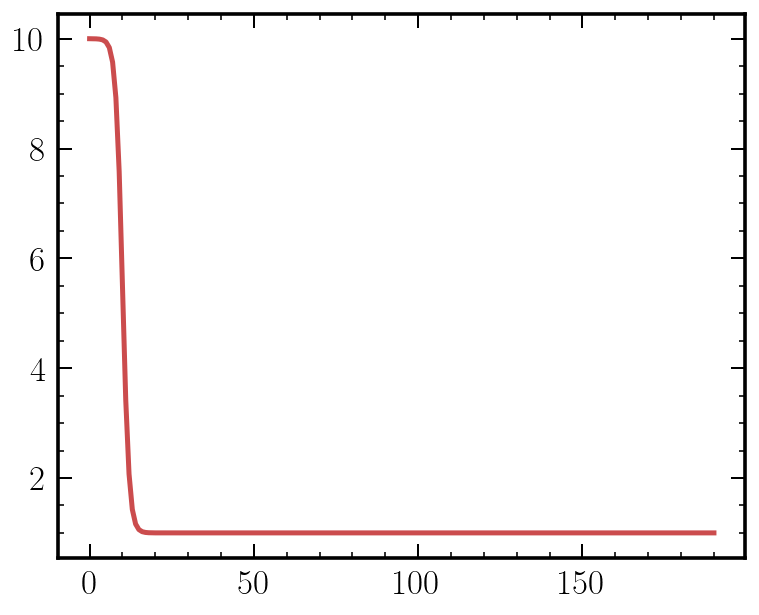

In [954]:
l_ary = np.arange(lmax)

plt.plot(l_ary, 10 - 9 / (1 + np.exp(-(-10 + l_ary) / 1.)))

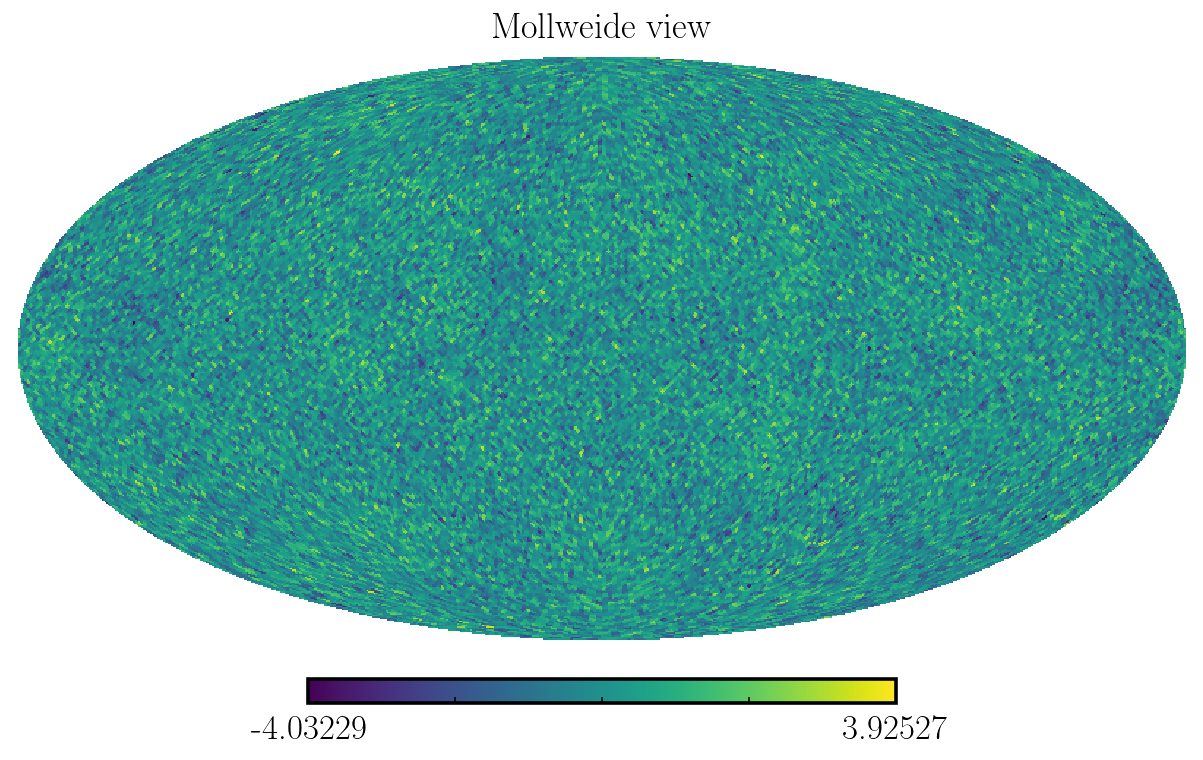

In [998]:
input_cl = sigma ** 2 * hp.nside2pixarea(64, degrees=False) * (10 - 9 / (1 + np.exp(-(-10 + l_ary) / 1.)))
synmap = hp.synfast(input_cl, nside=64)
hp.mollview(synmap)

(1.0, 51.0)

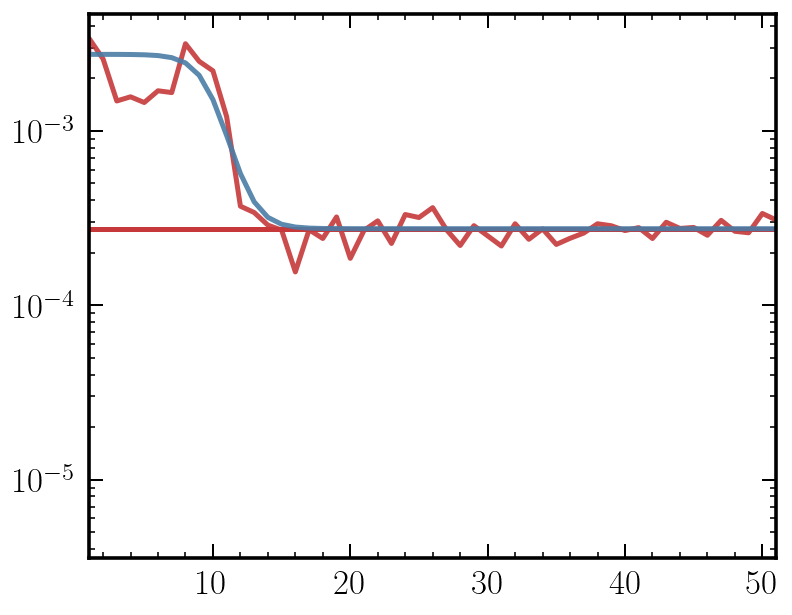

In [1001]:
plt.plot(hp.anafast(synmap))
plt.axhline(sigma ** 2 * hp.nside2pixarea(64, degrees=False) )
plt.plot(l_ary, sigma ** 2 * hp.nside2pixarea(64, degrees=False) * (10 - 9 / (1 + np.exp(-(-10 + l_ary) / 1.))))

plt.yscale("log")

plt.xlim(1, 51)

In [957]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '1936d60ac8f945b4b6873c96a4946f32'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-astrometry/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

In [958]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

In [959]:
list(density_estimator.children())[0].add_noise.sigma = 0.

In [960]:
n_trials = 30
n_test = 30

out = np.zeros((n_trials, n_test))

for i_trial in tqdm(range(n_trials)):
    
    sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150., alpha=-1.9)
    sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
    sim.set_subhalo_properties(sim.c200_SCP, distdep=False)
    
    sim.analysis_pipeline(get_sample=True)
    sim.mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T
    
    x_test = torch.Tensor(sim.mu_qsrs)
    
#     gn = GaussianNoise(sigma=0.0023)
#     x_test = gn(x_test).T

    lmax = 64 * 3 - 1
    
    sigma=0.0023
    input_cl = sigma ** 2 * hp.nside2pixarea(64, degrees=False) * (10 - 9 / (1 + np.exp(-(-10 + l_ary) / 1.)))
    noise_test = torch.Tensor([hp.synfast(input_cl, nside=64, pixwin=True), hp.synfast(input_cl, nside=64, pixwin=True)])
    
    x_test = (x_test.T + noise_test)
    
#     x_test = torch.Tensor(1 * [x_test.T]).contiguous() 

    theta_test = torch.linspace(10., 300., n_test).unsqueeze(1)

    out[i_trial, :] = [density_estimator(x_test.unsqueeze(0), theta_test
                                         [i].unsqueeze(0)).squeeze().detach().numpy() \
           for i in (range(n_test))]

  0%|          | 0/30 [00:00<?, ?it/s]

Simulating 1226 subhalos between 7.0 and 10.0


Simulating 1250 subhalos between 7.0 and 10.0
Simulating 1152 subhalos between 7.0 and 10.0
Simulating 1194 subhalos between 7.0 and 10.0
Simulating 1211 subhalos between 7.0 and 10.0
Simulating 1151 subhalos between 7.0 and 10.0
Simulating 1235 subhalos between 7.0 and 10.0
Simulating 1181 subhalos between 7.0 and 10.0
Simulating 1198 subhalos between 7.0 and 10.0
Simulating 1222 subhalos between 7.0 and 10.0
Simulating 1183 subhalos between 7.0 and 10.0
Simulating 1221 subhalos between 7.0 and 10.0
Simulating 1224 subhalos between 7.0 and 10.0
Simulating 1233 subhalos between 7.0 and 10.0
Simulating 1215 subhalos between 7.0 and 10.0
Simulating 1219 subhalos between 7.0 and 10.0
Simulating 1141 subhalos between 7.0 and 10.0
Simulating 1289 subhalos between 7.0 and 10.0
Simulating 1294 subhalos between 7.0 and 10.0
Simulating 1227 subhalos between 7.0 and 10.0
Simulating 1264 subhalos between 7.0 and 10.0
Simulating 1216 subhalos between 7.0 and 10.0
Simulating 1174 subhalos between 7

In [961]:
out_mean_lsnoise = np.mean(out, axis=0)

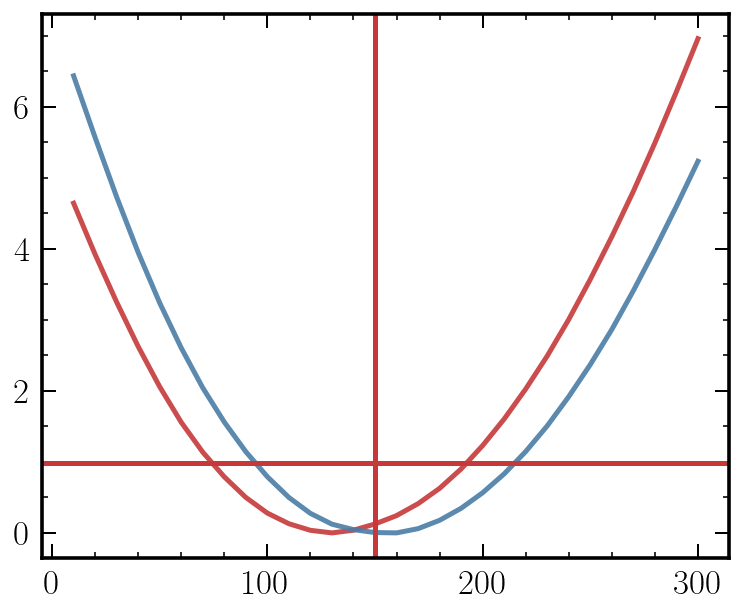

In [1018]:
llrmin, llrmax = 0., 15.

llr_lsnoise = - 2 * out_mean_lsnoise
llr_lsnoise -= np.min(llr_lsnoise)
llr_lsnoise = np.clip(llr_lsnoise, llrmin, llrmax)

plt.plot(theta_test.squeeze().detach().numpy(), llr_lsnoise)

llr = - 2 * out_mean
llr -= np.min(llr)
llr = np.clip(llr, llrmin, llrmax)

plt.plot(theta_test.squeeze().detach().numpy(), llr)

plt.axhline(chi2.isf(1 - .68, 1))
plt.axvline(150)

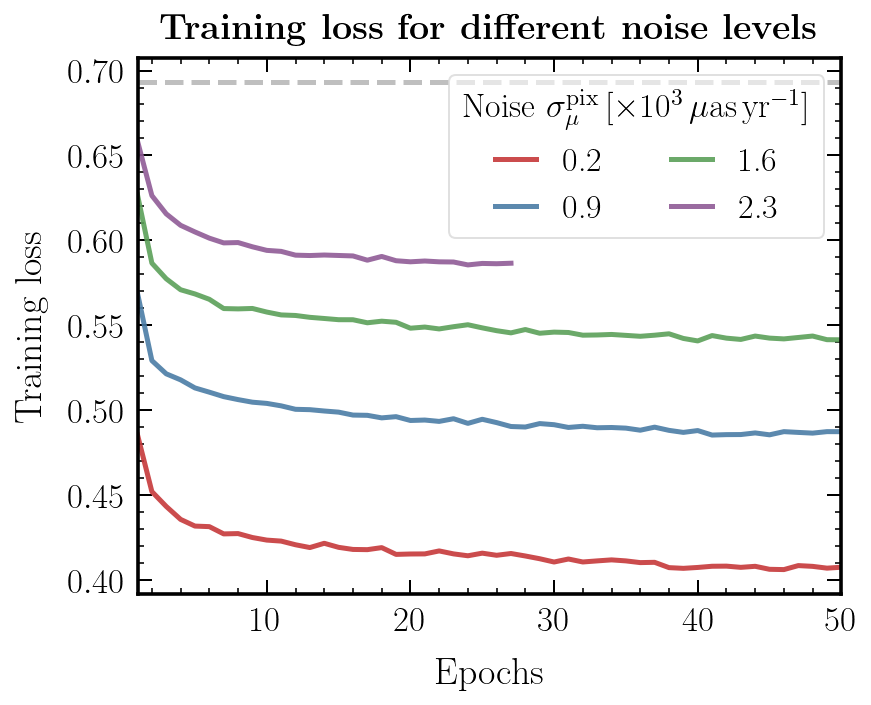

In [1017]:
plt.rcParams['legend.title_fontsize'] = 17

sigma_noise_all = np.linspace(0.0002, 0.003, 5) * 1000

run_id_list = ['c47674d2d8744dfab79d40c06f3b8ac0', 
               '303ceae8593c4ab78a573e1a3b1d83b1', '1936d60ac8f945b4b6873c96a4946f32', 'ede8a36abe9d4baf9dd8bbfbf7d0f158']

for i_r, run_id in enumerate(run_id_list):
    train_loss = np.loadtxt('../data/logs/mlruns/0/{}//metrics/train_loss_epoch'.format(run_id))
    plt.plot(np.arange(1, len(train_loss[:, 1][::2]) + 1), train_loss[:, 1][::2],
                           label=np.round(sigma_noise_all[i_r], 3), color=cols_default[i_r])
#     val_loss = np.loadtxt('../data/logs/mlruns/0/{}//metrics/val_loss'.format(run_id))
#     plt.plot(np.arange(1, len(val_loss[:, 1][::2]) + 1), val_loss[:, 1][::2],
#                            label=np.round(sigma_noise_all[i_r], 3), color=cols_default[i_r], ls='--')

plt.axhline(.693, ls='--', alpha=0.5, color='grey')
plt.xlim(1, 50)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.legend(frameon=True, framealpha=0.6, ncol=2, handlelength=1.2, title=r"Noise $\sigma_\mu^\mathrm{pix}\,[\times 10^3\,\mu$as\,yr$^{-1}$]")

plt.title(r"\bf{Training loss for different noise levels}", y=1.008)

plt.tight_layout()
plt.savefig("../paper/ml4ps/figures/training_loss.pdf")